In [459]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('merged_data.csv', sep='\t', encoding='utf-8')

df.describe()

,yearweek,ACCI,AUTR,INCN,INCU,SUAP,ope_total,inc_grippe,inc_diarrhee,inc_varicelle,has_vacation,temperature_max,temperature_min,temperature_average,total_snow_cm,precipitation_mm
count,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000
mean,201373.382060,82.040698,172.825581,6.067276,118.610465,1261.241694,1640.785714,6566.436877,13367.447674,2197.927741,0.799834,20.419435,5.674419,12.588920,0.051495,5.092525
std,227.528205,17.793145,154.637095,7.354663,30.607405,153.192973,205.687463,13627.580424,8053.446812,1907.110615,0.400291,7.895577,5.501785,6.211607,0.373818,5.080283
min,201001.000000,39.000000,35.000000,0.000000,57.000000,909.000000,1160.000000,0.000000,1721.000000,0.000000,0.000000,-1.000000,-10.000000,-5.710000,0.000000,0.000000
25%,201152.000000,70.000000,85.000000,1.000000,99.000000,1152.000000,1518.000000,124.000000,7540.000000,803.000000,1.000000,13.750000,1.000000,7.140000,0.000000,1.300000
50%,201349.500000,81.500000,117.000000,3.000000,112.000000,1261.000000,1608.000000,878.000000,11796.000000,1746.000000,1.000000,21.000000,6.000000,13.140000,0.000000,3.300000
75%,201549.250000,93.000000,225.000000,9.000000,131.000000,1364.000000,1739.000000,4163.000000,17868.000000,2876.000000,1.000000,27.000000,10.000000,18.140000,0.000000,8.000000
max,201752.000000,145.000000,2107.000000,50.000000,296.000000,1972.000000,3763.000000,103790.000000,61601.000000,9572.000000,1.000000,37.000000,16.000000,24.290000,5.600000,30.300000


In [460]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

model_random_forest = StandardScaler()

# All columns except yearweek and all interventions numbers
features_suap_random_forest = df.columns[7:]
to_predict_suap_random_forest = 'SUAP'

X_suap_random_forest = df[features_suap_random_forest]
y_suap_random_forest = df[to_predict_suap_random_forest]

X_train_suap_random_forest, X_test_suap_random_forest, y_train_suap_random_forest, y_test_suap_random_forest = train_test_split(X_suap_random_forest, y_suap_random_forest, test_size=0.25)

X_train_suap_random_forest = model_random_forest.fit_transform(X_train_suap_random_forest)
X_test_suap_random_forest = model_random_forest.transform(X_test_suap_random_forest)

suap_random_forest_model = RandomForestRegressor(random_state=1)
suap_random_forest_model.fit(X_train_suap_random_forest, y_train_suap_random_forest)
y_predicted_suap_random_forest = suap_random_forest_model.predict(X_test_suap_random_forest)

mean_absolute_error(y_test_suap_random_forest, y_predicted_suap_random_forest)


25.17677740863788

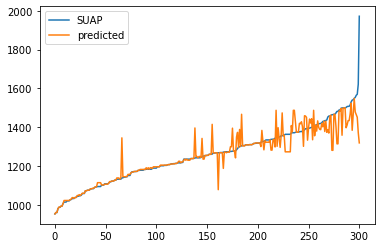

In [461]:
# plt.plot(y_test_suap_random_forest, label = "test")
# # plt.plot(y_predicted_suap_random_forest, label = "predicted")
# plt.show()

comparison = pd.DataFrame(y_test_suap_random_forest)
comparison['predicted'] = y_predicted_suap_random_forest

comparison = comparison.sort_values(by=['SUAP'])

comparison = comparison.reset_index(drop=True)

comparison.plot()

In [592]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.losses import MeanSquaredError, MeanAbsoluteError
from keras.layers.core import Dropout

##### FIX for "Blas GEMM launch failed" Error
##### see https://stackoverflow.com/a/60699372/12182226
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#####

# All columns except yearweek and all interventions numbers
features_nn = df.columns[7:]
to_predict_nn = 'SUAP'

X_nn = df[features_nn]
y_nn = df[to_predict_nn]

train_X_nn, val_X_nn, train_y_nn, val_y_nn = train_test_split(X_nn, y_nn, test_size=0.40)

# normalize
transformer = Normalizer().fit(X_nn) # fit doesn't affect the data
train_X_nn = pd.DataFrame(transformer.transform(train_X_nn), columns=features_nn)
val_X_nn = pd.DataFrame(transformer.transform(val_X_nn), columns=features_nn)

model_nn = Sequential()

# Adding the input layer and the first hidden layer
#        the second hidden layer
#        the output layer

model_nn.add(Dense(16, activation='relu', kernel_initializer='he_normal', input_dim=9))
model_nn.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
model_nn.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model_nn.add(Dense(1)) #relu, elu, softplus, selu ...

adam_opt = Adam(learning_rate=0.1) # https://keras.io/api/optimizers/

from keras import metrics
model_nn.compile(optimizer=adam_opt, loss="mse", metrics=[metrics.mean_squared_error, metrics.mean_absolute_error])
model_nn.fit(train_X_nn, train_y_nn, epochs=50, batch_size=10, verbose=1)

val_predictions_nn = model_nn.predict(val_X_nn)
val_mae_mlp = mean_absolute_error(val_y_nn, val_predictions_nn)

display(val_mae_mlp)

# loss = model.evaluate(X_nn, y_nn, verbose=0)
# display(loss)

Epoch 1/50
73/73 [==============================] - 0s 3ms/step - loss: 390148.3750 - mean_squared_error: 390148.3750 - mean_absolute_error: 435.0826
Epoch 2/50
73/73 [==============================] - 0s 4ms/step - loss: 20448.9824 - mean_squared_error: 20448.9824 - mean_absolute_error: 116.2012
Epoch 3/50
73/73 [==============================] - 0s 3ms/step - loss: 19708.1816 - mean_squared_error: 19708.1816 - mean_absolute_error: 114.1975
Epoch 4/50
73/73 [==============================] - 0s 3ms/step - loss: 19013.2832 - mean_squared_error: 19013.2793 - mean_absolute_error: 113.6545
Epoch 5/50
73/73 [==============================] - 0s 3ms/step - loss: 19812.3691 - mean_squared_error: 19812.3691 - mean_absolute_error: 114.7379
Epoch 6/50
73/73 [==============================] - 0s 3ms/step - loss: 23280.2051 - mean_squared_error: 23280.2051 - mean_absolute_error: 123.7982
Epoch 7/50
73/73 [==============================] - 0s 3ms/step - loss: 19110.5215 - mean_squared_error: 19110

107.48152407570993

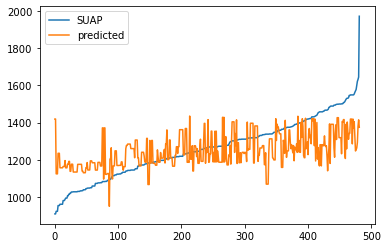

In [593]:
comparison_nn = pd.DataFrame(val_y_nn)
comparison_nn['predicted'] = val_predictions_nn
comparison_nn = comparison_nn.sort_values(by=[to_predict_nn])

comparison_nn = comparison_nn.reset_index(drop=True)

comparison_nn.plot()